In [12]:
import numpy as np
import matplotlib.pyplot as plt
# from sklearn import datasets
# from sklearn import svm
from sklearn import *
from sklearn.metrics import roc_curve, auc
import optunity
import optunity.metrics
import time

%matplotlib inline

In [2]:
# digits = datasets.load_digits()  # This is the old toy data, 1797x8x8

digits = datasets.fetch_mldata('MNIST original') # This is the full data, 70000x28x28

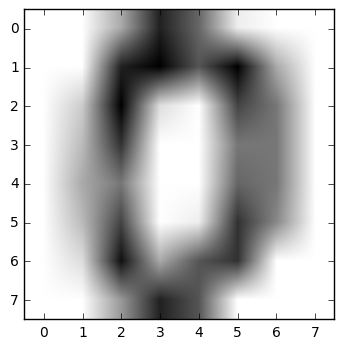

0


In [3]:
size = int(np.sqrt(len(digits.data[0])))
Shape = digits.data[0].reshape((size,size))
plt.imshow(Shape, cmap=plt.cm.gray_r)
plt.show()
print digits.target[0]

# First Crack
#### I will sort these into two groups for binary classification. 0-4 will be classifed as 0, 5-9 as 1.

In [3]:
labels = np.where(digits.target>4, np.ones(digits.target.shape), np.zeros(digits.target.shape))

#### Split the data into 80% training and 20% test sets.

In [4]:
X = np.float64(digits.data)
y = labels
# X = preprocessing.StandardScaler().fit_transform(X)
# y = preprocessing.label_binarize(y, classes=[0,1])

In [10]:
X_train, X_test, y_train, y_test = \
            model_selection.train_test_split(X, y, test_size=2./7)

# The cross_validate method already takes this into account
# X_train, X_validate, y_train, y_validate = \
#             model_selection.train_test_split(X_train, y_train, test_size=.3)

print y_train[:10]

[ 0.  1.  0.  1.  0.  1.  0.  0.  1.  1.]


In [11]:
X_train.shape

(50000L, 784L)

In [ ]:
for machine in [svm.SVC(  kernel='linear',decision_function_shape='ovr',C =1.0,gamma='auto',tol=.01),
                svm.SVC(  kernel='rbf'   ,decision_function_shape='ovr',C =1.0,gamma='auto',tol=.01),
                svm.NuSVC(kernel='linear',decision_function_shape='ovr',nu=.05,gamma='auto',tol=.01),
                svm.NuSVC(kernel='rbf'   ,decision_function_shape='ovr',nu=.05,gamma='auto',tol=.01)]:
    start = time.clock()
    machine.fit(X_train,y_train)
    finish = time.clock()

    print 'Train Acc:',machine.score(X_train,y_train)
    print 'Test Acc: ',machine.score(X_test ,y_test )
    print 'Time:',finish-start

#### We want a base case. I will run a couple SVMs on this data, linear and kernalized. That will be the base probability.

In [20]:
def train_linear_svm( data, labels, C):
    model = svm.SVC(kernel='linear', C=C)
    model.fit(data, labels)
    return model


search_linear_low = {'linear': {'C': [0,1]}}
search_linear_high = {'linear': {'C': [2,10]}}

@optunity.cross_validated(x=X_train, y=y_train, num_folds=2)
def performance_linear(x_train, y_train, x_test, y_test, C=1.):
    
    model = train_linear_svm(x_train, y_train, C)
#     predictions = model.decision_function(x_test)
    return model.score(x_test, y_test)
#     return optunity.metrics.roc_auc(y_test, predictions, positive=True)

In [21]:
optimal_configuration_low, info_low, _ = optunity.maximize_structured(performance_linear, search_space=search_linear_low, num_evals=10)
print optimal_configuration_low
print 'Prediction on training data: %g' %info_low.optimum

# optimal_configuration_high, info_high, _ = optunity.maximize_structured(performance_linear, search_space=search_linear_high, num_evals=10)
# print optimal_configuration_high
# print info_high.optimum

svc = svm.SVC(kernel='linear', C=optimal_configuration_low['C']).fit(X_train, y_train)
linear_score = svc.score(X_test, y_test)
print 'Prediction on test data: %g' %linear_score

# svc = svm.SVC(kernel='linear', C=optimal_configuration_high['C']).fit(X_train, y_train)
# print svc.score(X_test, y_test)

{'C': 0.35009765625}
Prediction on training data: 0.887266
Prediction on test data: 0.897222


In [65]:
def train_svm( data, labels, kernel, C, gamma, degree, coef0):
    if kernel == 'linear':
        model = svm.SVC(kernel=kernel,C=C)
    elif kernel == 'poly':
        model = svm.SVC(kernel=kernel,C=C,degree=degree,coef0=coef0)
    elif kernel == 'rbf':
        model = svm.SVC(kernel=kernel,C=C,gamma=gamma)
    else:
        #raise ArgumentError("Noob")
        print 'Noob'
    
    model.fit(data, labels)
    return model

def train_rbf_svm( data, labels, C, gamma ):
    model = svm.SVC(C=C)
    model.fit(data, labels)
    return model

def train_poly_svm( data, labels, C, degree, coef0 ):
    model = svm.SVC(kernel='poly', C=C, degree=degree, coef0=coef0)
    model.fit(data, labels)
    return model

search_all = {'kernel': {'linear': {'C': [0,2]},
                            'rbf': {'gamma': [0,1], 'C': [0,10]},
                            'poly': {'degree': [2,5], 'C': [0,50], 'coef0': [0,1]}
                           }
             }

search_rbf = {'rbf': {'gamma': [0,3], 'C': [0,100]}}

search_poly = {'poly': {'degree': [2,5], 'C': [0,50], 'coef0': [0,1]}}

@optunity.cross_validated(x=X_train, y=y_train, num_folds=5)
def performance(x_train, y_train, x_test, y_test,
                n_neighbors=None, n_estimators=None, max_features=None,
                kernel=None, C=None, gamma=None, degree=None, coef0=None):
    
    model = train_svm(x_train, y_train, kernel, C, gamma, degree, coef0)
    predictions = model.decision_function(x_test)
    
    return optunity.metrics.roc_auc(y_test, predictions, positive=True)

@optunity.cross_validated(x=X_train, y=y_train, num_folds=5)
def performance_rbf(x_train, y_train, x_test, y_test,
                n_neighbors=None, n_estimators=None, max_features=None,
                kernel=None, C=None, gamma=None, degree=None, coef0=None):
    
    model = train_rbf_svm(x_train, y_train, C, gamma)
    predictions = model.decision_function(x_test)
    
    return optunity.metrics.roc_auc(y_test, predictions, positive=True)

@optunity.cross_validated(x=X_train, y=y_train, num_folds=5)
def performance_poly(x_train, y_train, x_test, y_test,
                n_neighbors=None, n_estimators=None, max_features=None,
                kernel=None, C=None, gamma=None, degree=None, coef0=None):
    
    model = train_poly_svm(x_train, y_train, C, degree, coef0)
    predictions = model.decision_function(x_test)
    
    return optunity.metrics.roc_auc(y_test, predictions, positive=True)

In [67]:
for i in xrange(10):
    optimal_configuration_rbf, info_rbf, _ = optunity.maximize_structured(performance_rbf, search_space=search_rbf, num_evals=300)
    print optimal_configuration_rbf
    print info_rbf.optimum
print 'Done'

{'C': 1.787109375, 'gamma': 0.712890625}
0.998912300667
{'C': 7.6123046875, 'gamma': 0.0849609375}
0.998912300667
{'C': 5.361328125, 'gamma': 0.435546875}
0.998912300667
{'C': 5.05859375, 'gamma': 1.99609375}
0.998912300667
{'C': 1.572265625, 'gamma': 1.818359375}
0.998912300667
{'C': 7.12890625, 'gamma': 0.42578125}
0.998912300667
{'C': 8.9697265625, 'gamma': 1.8994140625}
0.998912300667
{'C': 8.759765625, 'gamma': 0.255859375}
0.998912300667
{'C': 5.4833984375, 'gamma': 1.2841796875}
0.998912300667
{'C': 7.63671875, 'gamma': 1.16796875}
0.998912300667
Done


In [63]:
svc_rbf = svm.SVC(kernel='rbf',
    C=optimal_configuration_rbf['C'],
    gamma=optimal_configuration_rbf['gamma']).fit(X_train, y_train)

rbf_score = svc_rbf.score(X_test, y_test)

In [61]:
optimal_configuration_poly, info_poly, _ = optunity.maximize_structured(performance_poly, search_space=search_poly, num_evals=30)
print optimal_configuration_poly
print info_poly.optimum

{'C': 31.84476543339445, 'coef0': 0.46468926440731906, 'degree': 4.591399904128725}
0.998942176425


In [62]:
svc_poly = svm.SVC(kernel='poly',
    C=optimal_configuration_poly['C'],
    degree=optimal_configuration_poly['degree'],
    coef0=optimal_configuration_poly['coef0']).fit(X_train, y_train)

poly_score = svc_poly.score(X_test, y_test)

### Our Baseline then becomes:
Linear Classifier: {{linear_score}}

RBF Kernel: {{rbf_score}}

Poly Kernel: {{poly_score}}

### In this research, we will call various SVMs for each neuron which should give unique output. We want all the outputs from each SVM to be in [0,1], not necessarily binary. We won't use SVC here, but will switch to SVR (Support Vector Regression) using various kernels. The following are up for debate:
- Do I optimize the parameters before plugging them in?
- Do I cut out some of the training data at each step?
- Do I take a subset of features?
 - Which ones and how do I determine the best ones?

In [7]:
num_train = len(X_train)
num_test = len(X_test)
num_features = len(X_train[0])

Number of training points: {{num_train}}

Number of testing points: {{num_test}}

Number of features: {{num_features}}

#### I will assume for the time being that I don't want to optimize right now. I will use all linear kernels, with C=1, only taking in some of the features, randomly.

In [9]:
np.random.choice(np.arange(num_features), 20, replace=False)

array([12, 59, 24, 17, 13, 32, 51, 36, 27, 19, 22, 56, 63, 48, 38, 14, 45,
       20, 55, 62])

In [8]:
kernels = {2:'linear', 0:'rbf', 1:'poly'}

In [ ]:
Layer1_neurons = 40
X_train_layer_1 = np.zeros((num_train, Layer1_neurons))
X_test_layer_1 = np.zeros((num_test, Layer1_neurons))

for i in xrange(Layer1_neurons):
#     print i
    num_subset = 8    # This is the number of features to look at
    select_features = np.random.choice(np.arange(num_features), num_subset, replace=False)
    select_inputs = np.random.choice(np.arange(num_train), num_train/4, replace=False)
    kernel = kernels[np.random.randint(2)]
    C = 10*np.random.rand()
    degree = np.random.randint(3)+1
    gamma = 1./np.random.randint(5,15)
    coef0 = np.random.rand(1)[0]
        
    print kernel, C, degree, gamma, coef0
    
    svr = svm.SVR(kernel=kernel, C=C, degree=degree, gamma=gamma, coef0=coef0).fit(X_train[:,select_features][select_inputs], y_train[select_inputs])
    X_train_layer_1[:,i] = svr.predict(X_train[:,select_features])
    X_test_layer_1[:,i] = svr.predict(X_test[:,select_features])

print "Layer 1 trained"

Layer2_neurons = 10
X_train_layer_2 = np.zeros((num_train, Layer2_neurons))
X_test_layer_2 = np.zeros((num_test, Layer2_neurons))

for i in xrange(Layer2_neurons):
#     print i
    num_subset = 20    # This is the number of features to look at
    select_features = np.random.choice(np.arange(Layer1_neurons), num_subset, replace=False)
    select_inputs = np.random.choice(np.arange(num_train), num_train/4, replace=False)
    kernel = kernels[np.random.randint(2)]
    C = 10*np.random.rand()
    degree = np.random.randint(3)+1
    gamma = 1./np.random.randint(5,15)
    coef0 = np.random.rand(1)[0]
    
    svr = svm.SVR(kernel=kernel, C=C, degree=degree, gamma=gamma, coef0=coef0).fit(X_train_layer_1[:,select_features][select_inputs], y_train[select_inputs])

    X_train_layer_2[:,i] = svr.predict(X_train_layer_1[:,select_features])
    X_test_layer_2[:,i] = svr.predict(X_test_layer_1[:,select_features])

print "Layer 2 trained"

Layer3_neurons = 10
X_train_layer_3 = np.zeros((num_train, Layer3_neurons))
X_test_layer_3 = np.zeros((num_test, Layer3_neurons))

for i in xrange(Layer3_neurons):
#     print i
    num_subset = 10    # This is the number of features to look at
    select_features = np.random.choice(np.arange(Layer2_neurons), num_subset, replace=False)
    select_inputs = np.random.choice(np.arange(num_train), num_train/4, replace=False)
    kernel = kernels[np.random.randint(2)]
    C = 10*np.random.rand()
    degree = np.random.randint(3)+1
    gamma = 1./np.random.randint(5,15)
    coef0 = np.random.rand(1)[0]
    svr = svm.SVR(kernel=kernel, C=C, degree=degree, gamma=gamma, coef0=coef0).fit(X_train_layer_2[:,select_features][select_inputs], y_train[select_inputs])
    X_train_layer_3[:,i] = svr.predict(X_train_layer_2[:,select_features])
    X_test_layer_3[:,i] = svr.predict(X_test_layer_2[:,select_features])

print "Layer 3 trained"

poly 2.62009090299 1 0.142857142857 0.645337432897
poly 9.8455101055 3 0.2 0.644897305269


In [12]:
randomize_regular = np.random.choice(np.arange(num_features),num_subset, replace=False)
svc_generic = svm.SVC(kernel='linear', C=1).fit(X_train[:,randomize_regular], y_train)
print svc_generic.score(X_test[:,randomize_regular], y_test)

0.619444444444


In [13]:
randomize_research = np.random.choice(np.arange(Layer2_neurons),Layer2_neurons, replace=False)
svc_research = svm.SVC(kernel='linear').fit(X_train_layer_2[:,randomize_research], y_train)
print svc_research.score(X_test_layer_2[:,randomize_research], y_test)

0.894444444444


I'm gonna try to plot a probability curve

In [ ]:
normal_prob = []
research_prob_1_layer = []
research_prob_2_layer = []
research_prob_3_layer = []

for i in xrange(30):
    print i
    randomize_regular = np.random.choice(np.arange(num_features),64)
    kernel = kernels[np.random.randint(2)]
    C = 10*np.random.rand()
    degree = np.random.randint(3)+1
    gamma = 1./np.random.randint(5,15)
    coef0 = np.random.rand(1)[0]
    svc_generic = svm.SVC(kernel=kernel, C=C, degree=degree, gamma=gamma, coef0=coef0).fit(X_train[:,randomize_regular], y_train)
    normal_prob.append(svc_generic.score(X_test[:,randomize_regular], y_test))
    
    randomize_research = np.random.choice(np.arange(Layer1_neurons),Layer1_neurons)
    kernel = kernels[np.random.randint(2)]
    C = 10*np.random.rand()
    degree = np.random.randint(3)+1
    gamma = 1./np.random.randint(5,15)
    coef0 = np.random.rand(1)[0]
    svc_research = svm.SVC(kernel=kernel, C=C, degree=degree, gamma=gamma, coef0=coef0).fit(X_train_layer_1[:,randomize_research], y_train)
    research_prob_1_layer.append(svc_research.score(X_test_layer_1[:,randomize_research], y_test))
    
    randomize_research = np.random.choice(np.arange(Layer2_neurons),Layer2_neurons)
    kernel = kernels[np.random.randint(2)]
    C = 10*np.random.rand()
    degree = np.random.randint(3)+1
    gamma = 1./np.random.randint(5,15)
    coef0 = np.random.rand(1)[0]
    svc_research = svm.SVC(kernel=kernel, C=C, degree=degree, gamma=gamma, coef0=coef0).fit(X_train_layer_2[:,randomize_research], y_train)
    research_prob_2_layer.append(svc_research.score(X_test_layer_2[:,randomize_research], y_test))
    
    randomize_research = np.random.choice(np.arange(Layer3_neurons),Layer3_neurons)
    kernel = kernels[np.random.randint(2)]
    C = 10*np.random.rand()
    degree = np.random.randint(3)+1
    gamma = 1./np.random.randint(5,15)
    coef0 = np.random.rand(1)[0]
    svc_research = svm.SVC(kernel=kernel, C=C, degree=degree, gamma=gamma, coef0=coef0).fit(X_train_layer_3[:,randomize_research], y_train)
    research_prob_3_layer.append(svc_research.score(X_test_layer_3[:,randomize_research], y_test))

In [ ]:
import pandas as pd
import scipy.stats as stats

probs = pd.concat([pd.DataFrame(normal_prob, columns=['normal']),
                   pd.DataFrame(research_prob_1_layer, columns=['1 Layer']),
                   pd.DataFrame(research_prob_2_layer, columns=['2 Layer']),
                   pd.DataFrame(research_prob_3_layer, columns=['3 Layer'])],
                   axis=1)

plt.figure()
probs.plot(kind='density', figsize=(4,4), xlim=(.5,1), ylim=(0,100))

In [ ]:
probs.mean(axis=0)

In [ ]:
probs.std(axis=0)

In [ ]:
print X_test_layer_1

### I will try to get the ROC/AUC curve for the regular classifier and my creation

In [ ]:
y_regular_score = svm.SVC(kernel='linear').fit(X_train[:,randomize_regular], y_train).decision_function(X_test[:,randomize_regular])
y_research_score = svm.SVC(kernel='linear').fit(X_train_layer_1[:,randomize_research], y_train).decision_function(X_test_layer_1[:,randomize_research])

fpr_regular , tpr_regular, _ = roc_curve(y_test, y_regular_score)
roc_auc_regular = auc(fpr_regular, tpr_regular)

fpr_research , tpr_research, _ = roc_curve(y_test, y_research_score)
roc_auc_research = auc(fpr_research, tpr_research)

plt.figure()
lw = 2
plt.plot(fpr_regular, tpr_regular, color='darkorange',
         lw=lw, label='Normal ROC curve (area = %0.2f)' % roc_auc_regular)
plt.plot(fpr_research, tpr_research, color='r',
         lw=lw, label='Research ROC curve (area = %0.2f)' % roc_auc_research)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


# This is from online. The original code gives the ROC/AUC score on a multiclass problem, but it easily reduces down to binary.

In [ ]:
kernel = kernels[np.random.randint(3)]
C = 10*np.random.rand()
degree = np.random.randint(5)+1
gamma = np.random.rand(1)
coef0 = np.random.rand(1)*10 - 5
svr = svm.SVR(kernel=kernel, C=C, degree=degree, gamma=gamma, coef0=coef0).fit(X_train, y_train)
print svr.predict(X_test, y_test)

In [ ]:
kernels[2]